In [1]:
from    typing              import  *
from    typing_extensions   import  Self

from    tqdm.notebook       import  tqdm

import  numpy               as  np
import  matplotlib.pyplot   as  plt

import  torch
from    torch.utils.data    import  Dataset, DataLoader


from    pathlib             import  Path
root_dir    = r"/media/junseung/47a90e46-3a9d-467c-bbee-066752b68532/GWANGJAE"
path_root   = Path(root_dir)
path_lib    = path_root / "python_deep_numerical"
path_data   = path_root / "datasets"

import  sys
sys.path.append( str(path_lib) )
from    pytorch.layers                  import  FourierLandauLayer
from    pytorch.torch_numerical         import  utils
from    pytorch.utils                   import  initialize_weights


dtype  = torch.float32
dtype_complex = utils.dtype_real_to_complex(dtype)
device = torch.device('cuda:2')
__dtype_str = str(dtype).split(".")[-1]
dtype_and_device = {'dtype': dtype, 'device': device}
print(f"Device for computation\n>>> {device}")

Device for computation
>>> cuda:2


In [2]:
DIMENSION:  int     = 2
RESOLUTION: int     = 64
VHS_ALPHA:  float   = 0.0

_file = path_data / f"{__dtype_str}/Landau__alpha_{int(VHS_ALPHA)}__res_{RESOLUTION}.npz"
print(f"Loading data from\n>>> {_file}")
file = np.load(_file)

V_MAX:      float   = float(file['v_max'])
DELTA_V:    float   = (2*V_MAX) / RESOLUTION
FFT_NORM:   str     = 'forward'

VHS_COEFF:  float   = file['vhs_coeff']

Loading data from
>>> /media/junseung/47a90e46-3a9d-467c-bbee-066752b68532/GWANGJAE/datasets/float32/Landau__alpha_0__res_64.npz


In [3]:
class CustomDataset(Dataset):
    def __init__(
            self,
            distr:      torch.Tensor,
            gain_fft:   torch.Tensor,
            loss_fft:   torch.Tensor,
            vhs_alpha:  Optional[torch.Tensor]  = None,
            dim:        Optional[int]           = None,
            squeeze_space: bool = False,
        ) -> Self:
        self.dim:       int                         = dim
        self.distr:     torch.Tensor                = distr
        self.gain_fft:  torch.Tensor                = gain_fft
        self.loss_fft:  torch.Tensor                = loss_fft
        self.vhs_alpha: Optional[torch.Tensor]      = vhs_alpha
        self.__fft_dim: tuple[int] = tuple(range(1+dim, 1+2*dim))
        
        if squeeze_space:
            self.distr      = self.distr.reshape(distr.size(0), *distr.shape[-1-dim:])
            self.gain_fft   = self.gain_fft.reshape(gain_fft.size(0), *gain_fft.shape[-1-dim:])
            self.loss_fft   = self.loss_fft.reshape(loss_fft.size(0), *loss_fft.shape[-1-dim:])
            self.__fft_dim  = tuple(range(1, 1+dim))
            
        return
    
    
    def __getitem__(self, index: int) -> tuple[torch.Tensor]:
        if self.vhs_alpha:
            return self.distr[index], self.gain_fft[index], self.loss_fft[index], self.vhs_alpha[index]
        else:
            return self.distr[index], self.gain_fft[index], self.loss_fft[index]
    
    def __len__(self) -> int:
        return self.distr.size(0)
    
    
    @property
    def fft_dim(self) -> tuple[int]:
        return self.__fft_dim

In [4]:
dataset  = CustomDataset(
    torch.tensor(file['data'], dtype=dtype),
    torch.tensor(file['gain_fft'], dtype=dtype_complex),
    torch.tensor(file['loss_fft'], dtype=dtype_complex),
    dim=DIMENSION,
    squeeze_space=False,
)
dataloader  = DataLoader(dataset, batch_size=256, shuffle=True)
FFT_DIM = dataset.fft_dim

In [5]:
specnet     = FourierLandauLayer(DIMENSION, 8).to(device)
initialize_weights(specnet, 'xavier uniform')
optimizer   = torch.optim.Adam(specnet.parameters(), lr=1e-2)

print(specnet)

==============================< FourierLandauLayer >==============================
[ Subnetworks ]

----------------------------------------------------------------------------------
[ Parameters ]
( params_id )
- Shape:       [16, 16, 1]
- Data type:   torch.complex64
( params_proj )
- Shape:       [16, 16, 1, 2, 2]
- Data type:   torch.complex64
----------------------------------------------------------------------------------
Number of parameters: 2560


In [6]:
NUM_EPOCHS: int = 10000
dv = DELTA_V**DIMENSION
specnet.train()

data:       torch.Tensor
gain_fft:   torch.Tensor
loss_fft:   torch.Tensor

for epoch in tqdm(range(1, 1+NUM_EPOCHS)):
    abs_error:  float = 0.0
    rel_error:  float = 0.0
    
    for data, gain_fft, loss_fft in dataloader:
        data        = data.to(device)
        data_fft:   torch.Tensor = torch.fft.fftn(data, dim=FFT_DIM, norm=FFT_NORM)
        gain_fft    = gain_fft.to(device)
        loss_fft    = loss_fft.to(device)
        target_collision:   torch.Tensor = torch.fft.ifftn(gain_fft-loss_fft, dim=FFT_DIM, norm=FFT_NORM).real

        # pred_gain_fft = sm_object.compute_gain_fft(None, data_fft)
        # pred_loss_fft = sm_object.compute_loss_fft(None, data_fft)
        # pred_gain_fft = specnet.compute_gain_fft(data_fft)
        # pred_loss_fft = specnet.compute_loss_fft(data_fft)
        pred_fft        = specnet.forward(data_fft)
        pred_collision: torch.Tensor = torch.fft.ifftn(pred_fft, dim=FFT_DIM, norm=FFT_NORM).real

        _data_size = len(data)
        _abs_error = utils.absolute_error(pred_collision, target_collision).mean()
        _rel_error = utils.relative_error(pred_collision, target_collision).mean()
        abs_error += _abs_error.item() * _data_size
        rel_error += _rel_error.item() * _data_size
        
        optimizer.zero_grad()
        _rel_error.backward()
        optimizer.step()
        
    __abs_scale = dv/len(dataset)
    __rel_scale = 1.0/len(dataset)
    abs_error       *= __abs_scale
    rel_error       *= __rel_scale
    if epoch%10==0 or epoch==1:
        print(f"[ Epoch {str(epoch).zfill(len(str(NUM_EPOCHS)))} ]")
        print(f"* Absolute error:       {abs_error:.4e}")
        print(f"* Relative error:       {rel_error:.4e}")
        print('-'*80)
    if rel_error < 1e-3:
        print(f"Achieved relative error {_rel_error:.4e} at epoch {epoch}.")
        break

specnet.eval()

  0%|          | 0/10000 [00:00<?, ?it/s]

[ Epoch 00001 ]
* Absolute error:       2.0245e-01
* Relative error:       9.1070e-01
--------------------------------------------------------------------------------
[ Epoch 00010 ]
* Absolute error:       1.3140e-01
* Relative error:       3.6418e-01
--------------------------------------------------------------------------------
[ Epoch 00020 ]
* Absolute error:       7.6638e-02
* Relative error:       2.1465e-01
--------------------------------------------------------------------------------
[ Epoch 00030 ]
* Absolute error:       5.5057e-02
* Relative error:       1.4664e-01
--------------------------------------------------------------------------------
[ Epoch 00040 ]
* Absolute error:       4.9535e-02
* Relative error:       1.2833e-01
--------------------------------------------------------------------------------
[ Epoch 00050 ]
* Absolute error:       4.8387e-02
* Relative error:       1.2347e-01
-------------------------------------------------------------------------------

FourierLandauLayer()

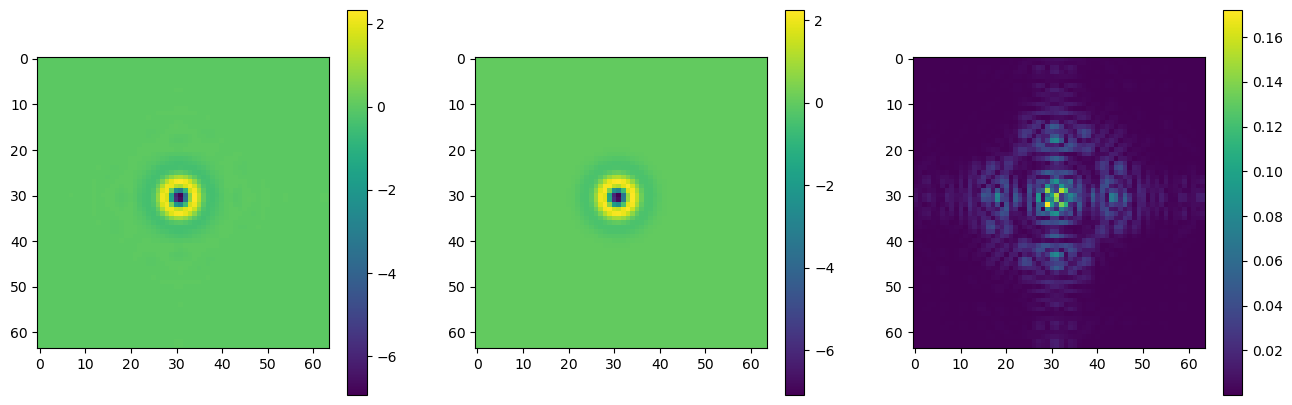

In [7]:
idx = torch.randint(0, len(data), (1,)).item()
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
d1 = pred_collision[idx].reshape(RESOLUTION, RESOLUTION).detach().cpu().numpy()
d2 = target_collision[idx].reshape(RESOLUTION, RESOLUTION).detach().cpu().numpy()
d3 = (pred_collision-target_collision)[idx].reshape(RESOLUTION, RESOLUTION).detach().cpu().numpy()
fig.colorbar(axes[0].imshow(d1))
fig.colorbar(axes[1].imshow(d2))
fig.colorbar(axes[2].imshow(np.abs(d3)))
plt.show()

In [8]:
torch.save(
    obj = specnet.cpu().state_dict(),
    f   = path_data / f"Landau__alpha_{int(VHS_ALPHA)}__res_{RESOLUTION}__specnet__deg_8.pth"
)

End of file